In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import imageio
import os
from tqdm.notebook import tqdm

# import torch
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
# from models.transform_models import SphericalTransformer, InverseSphericalTransformer

In [2]:
import time
with open('/shared/scratch/0/home/v_nishchay_nilabh/oasis_data/scans/OASIS_OAS1_0001_MR1/seg4_onehot.npy', "rb") as f:
    start = time.time()
    data = f.read()
    end = time.time()
    print(f"Read {len(data) / 1024 / 1024:.2f} MB in {end - start:.2f} seconds")

Read 80.00 MB in 0.05 seconds


In [3]:
# Load one-hot encoded segmentation map
path = '/shared/scratch/0/home/v_nishchay_nilabh/oasis_data/scans/OASIS_OAS1_0001_MR1/seg4_onehot.npy'
seg = np.load(path, mmap_mode='r')  # shape: (C, D, H, W)

print("Shape:", seg.shape)  # Should be (4, 256, 256, 256)

Shape: (5, 256, 256, 256)


In [ ]:
from get_data import SegDataset

train_dataset = SegDataset('/shared/scratch/0/home/v_nishchay_nilabh/oasis_data/train.txt', '/shared/scratch/0/home/v_nishchay_nilabh/oasis_data/scans/OASIS_OAS1_0406_MR1/seg4_onehot.npy')

Loading subject paths from: /shared/scratch/0/home/v_nishchay_nilabh/oasis_data/train.txt
Loaded 330 subject paths.
Target size set to: (128, 128, 128)
Loading template from: /shared/scratch/0/home/v_nishchay_nilabh/oasis_data/scans/OASIS_OAS1_0406_MR1/seg4_onehot.npy
Loaded template with shape (one-hot): (5, 256, 256, 256)


In [4]:
# 1. Get hard labels (argmax across channels)
label_map = np.argmax(seg, axis=0)  # shape: (D, H, W)

# 2. Binarize: anything not background becomes 1
# binary_mask = (label_map != 0).astype(np.int32)

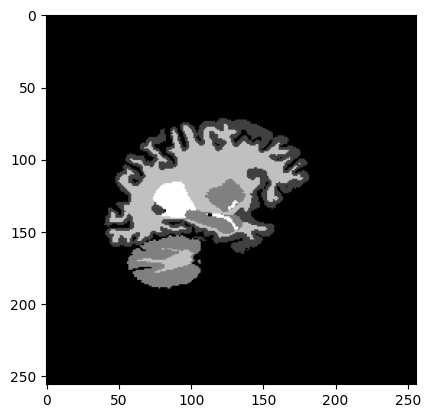

In [5]:
plt.imshow(label_map[100], cmap="gray")

In [6]:
import numpy as np

def mask_to_spherical(label_map: np.ndarray) -> np.ndarray:
    """
    Converts a 3D mask with labels 0 to 4 into spherical coordinates
    for each class relative to its own centroid.

    Args:
        label_map: A 3D NumPy array with integer values from 0 to 4.

    Returns:
        A NumPy array of shape (N, 4) where each row is (r_scaled, theta, phi, class_id).
    """
    all_coords = []

    for class_id in range(1, 5):  # Assuming classes 1 to 4 are valid
        binary_mask = (label_map == class_id)
        coords = np.argwhere(binary_mask).astype(np.float64)
        if coords.shape[0] == 0:
            continue

        centroid = coords.mean(axis=0)
        translated_coords = coords - centroid
        z, y, x = translated_coords[:, 0], translated_coords[:, 1], translated_coords[:, 2]

        r_prime = np.sqrt(x**2 + y**2 + z**2)
        r_prime[r_prime == 0] = 1e-9

        theta = np.arccos(z / r_prime)
        phi = np.arctan2(y, x)
        phi[phi < 0] += 2 * np.pi

        r_max = np.max(r_prime)
        r_scaled = r_prime * (100 / r_max) if r_max > 0 else 0

        spherical_coords = np.vstack((r_scaled, theta, phi)).T
        class_column = np.full((spherical_coords.shape[0], 1), class_id)
        spherical_with_class = np.hstack((spherical_coords, class_column))

        all_coords.append(spherical_with_class)

    if all_coords:
        return np.vstack(all_coords)
    else:
        return np.empty((0, 4))


# --- Example Usage ---
# Get the spherical coordinates
spherical_coordinates = mask_to_spherical(label_map)

print("Shape of spherical coordinates array:", spherical_coordinates.shape)
print("First 5 coordinates (r, theta, phi):\n", spherical_coordinates[:5])

Shape of spherical coordinates array: (941146, 4)
First 5 coordinates (r, theta, phi):
 [[72.29960855  2.97634512  5.12702389  1.        ]
 [72.13467518  2.99067138  5.16996122  1.        ]
 [71.9202494   3.01173652  5.1134302   1.        ]
 [71.98791579  3.00472678  5.22195986  1.        ]
 [72.16219164  2.98818435  3.7456322   1.        ]]


In [ ]:
def create_spherical_gif(spherical_coords: np.ndarray,
                         r_bins: int = 250,
                         theta_bins: int = 180,
                         phi_bins: int = 360,
                         frame_duration: float = 0.05):
    """
    Generates a GIF from spherical coordinates, animating through radial shells.

    Args:
        spherical_coords: (N, 3) array of (r, theta, phi) points.
        output_filename: The name of the output GIF file.
        r_bins: The number of radial shells to create (number of frames).
        theta_bins: The resolution for the polar angle (theta-axis).
        phi_bins: The resolution for the azimuthal angle (phi-axis).
        frame_duration: The duration of each frame in the GIF, in seconds.
    """
    if spherical_coords.shape[0] == 0:
        print("Coordinate array is empty. No GIF created.")
        return

    # Extract r, theta, phi for convenience
    r, theta, phi = spherical_coords[:, 0], spherical_coords[:, 1], spherical_coords[:, 2]

    # Define the edges of our bins
    # r is scaled 0-100, theta is 0-pi, phi is 0-2pi
    r_edges = np.linspace(0, 120, r_bins + 1)
    theta_edges = np.linspace(0, np.pi, theta_bins + 1)
    phi_edges = np.linspace(0, 2 * np.pi, phi_bins + 1)

    frame_files = []
    temp_dir = "tmp_slices"
    os.makedirs(temp_dir, exist_ok=True)

    print(f"Generating {r_bins} frames...")
    # Generate a frame for each radial shell
    for i in tqdm(range(r_bins)):
        r_min, r_max = r_edges[i], r_edges[i+1]

        # 1. Select points within the current radial shell
        shell_mask = (r >= r_min) & (r < r_max)
        shell_thetas = theta[shell_mask]
        shell_phis = phi[shell_mask]

        # 2. Create the 2D histogram
        # Note: Set density=True to normalize counts, which can be better for visualization
        hist, _, _ = np.histogram2d(shell_thetas, shell_phis, bins=[theta_edges, phi_edges])

        # 3. Plot the histogram as an image
        fig, ax = plt.subplots(figsize=(8, 4))
        # We transpose the histogram (H.T) so theta is on the y-axis
        im = ax.imshow(hist.T, origin='lower', cmap='viridis', aspect='auto',
                       extent=[np.rad2deg(0), np.rad2deg(2*np.pi), np.rad2deg(0), np.rad2deg(np.pi)])

        ax.set_xlabel("Azimuthal Angle (φ) [degrees]")
        ax.set_ylabel("Polar Angle (θ) [degrees]")
        ax.set_title(f"Radius Shell: {r_min:.1f} to {r_max:.1f}")
        fig.colorbar(im, ax=ax, label="Point Density")
        plt.tight_layout()

        # 4. Save the frame
        frame_path = os.path.join(temp_dir, f"frame_{i:03d}.png")
        plt.savefig(frame_path)
        plt.close(fig)  # Close the figure to free memory
        frame_files.append(frame_path)
        
    output_filename = f"../images/across_r{r_bins}_the{theta_bins}_phi{phi_bins}.gif"

    # Step 3: Compile frames into a GIF
    print("Compiling GIF...")
    with imageio.get_writer(output_filename, mode='I', duration=frame_duration, loop=0) as writer:
        for frame_path in frame_files:
            image = imageio.imread(frame_path)
            writer.append_data(image)
    
    print(f"✅ GIF saved as {output_filename}")


# --- Example Usage ---
# Assuming 'spherical_coordinates' is the output from the previous step
# (If you need to re-run, uncomment the two lines below)
# from previous_script import mask_to_spherical
# spherical_coordinates = mask_to_spherical(my_mask)

create_spherical_gif(spherical_coordinates)

Generating 500 frames...


  0%|          | 0/500 [00:00<?, ?it/s]

Compiling GIF...


/tmp/ipykernel_3109648/338863724.py:72: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame_path)


✅ GIF saved as ../images/across_r500_the360_phi720.gif
